# Twitter emotions sentiment analysis

## Agenda

1. [Packages Import](#Packages-Import)

2. [Data Loading and Exploration](#Data-Loading-and-Exploration)

3. [Data Preprocessing](#Data-Preprocessing)
   - [3.1. Lowercasing](#Lowercasing)
   - [3.2. Removing punctuation, emoticons, special characters, and URLs](#Removing-punctuation-emoticons-special-characters-and-URLs)
   - [3.3. Stop words removal](#Stop-words-removal)
   - [3.4. Duplicated and empty texts removal](#Duplicated-and-empty-texts-removal)
   - [3.5. Tokenization (to words)](#Tokenization-to-words)
   - [3.6. Stemming](#Stemming)
   - [3.7. Tokenization (to numbers)](#Tokenization-to-numbers)
   - [3.8. Trim & pad text](#Trim--pad-text)
   - [3.9. Split data](#Split-data)

4. [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-EDA)
   - [4.1. Emotions category distribution](#Emotions-category-distribution)
   - [4.2. Texts length distribution](#Texts-length-distribution)
   - [4.3. Common words frequency](#Common-words-frequency)

5. [Model Building and Configuration](#Model-Building-and-Configuration)
   - [5.1. LSTM model architecture](#LSTM-model-architecture)
   - [5.2. Bidirectional LSTM model architecture](#Bidirectional-LSTM-model-architecture)
   - [5.3. GRU model architecture](#GRU-model-architecture)
   - [5.4. Model training configuration](#Model-training-configuration)

6. [Hyperparameter Tuning and Training](#Hyperparameter-Tuning-and-Training)
   - [6.1. MLflow metrics and artifacts setup](#MLflow-metrics-and-artifacts-setup)
   - [6.2. MLflow experiment setup](#MLflow-experiment-setup)
   - [6.3. Hyperparameter grid search](#Hyperparameter-grid-search)

7. [Model Evaluation and Validation](#Model-Evaluation-and-Validation)
   - [7.1. Selected model loading](#Selected-model-loading)
   - [7.2. Loss & accuracy](#Loss--accuracy)
   - [7.3. Classification report](#Classification-report)
   - [7.4. Confusion matrix](#Confusion-matrix)


## Packages import

In [1]:
import myvisualization as mv
import mypreprocessing as mp

import pandas as pd
import numpy as np
import collections
import os
import json
import itertools

import mlflow
import mlflow.keras
from mlflow.models.signature import infer_signature

from sklearn.metrics import  classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Flatten, Dropout, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.regularizers import l1_l2

## Data Loading and Exploration

In [2]:

df = pd.read_parquet(r'..\data\train-00000-of-00001.parquet', engine='pyarrow')
df['label'] = df['label'].astype('int')
df['text'] = df['text'].astype('string')

value_label_dict = {
    0: 'sadness', 
    1: 'joy', 
    2: 'love', 
    3: 'anger', 
    4: 'fear', 
    5: 'surprise'}

print(f'Dataset length: {len(df)}\n')
print(value_label_dict)
print(df.head())

Dataset length: 416809

{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
                                                text  label
0  i feel awful about it too because it s my job ...      0
1                              im alone i feel awful      0
2  ive probably mentioned this before but i reall...      1
3           i was feeling a little low few days back      0
4  i beleive that i am much more sensitive to oth...      2


## Data Preprocessing

###  Lowercasing

In [3]:
df['text'] = mp.lower_case(df['text'])
df['text'].head()

0    i feel awful about it too because it s my job ...
1                                im alone i feel awful
2    ive probably mentioned this before but i reall...
3             i was feeling a little low few days back
4    i beleive that i am much more sensitive to oth...
Name: text, dtype: string

### Removing punctuation, emoticons, special characters and URLs

In [4]:
df['text'] = mp.sanitize(df['text'])
df['text'].head()

0    i feel awful about it too because it s my job ...
1                                im alone i feel awful
2    ive probably mentioned this before but i reall...
3             i was feeling a little low few days back
4    i beleive that i am much more sensitive to oth...
Name: text, dtype: object

### Stop Words Removal

In [5]:
df['text'] = mp.remove_stop_words(df['text'])
df['text'].head()

0           feel awful job get position succeed happen
1                                  im alone feel awful
2    ive probably mentioned really feel proud actua...
3                         feeling little low days back
4    beleive much sensitive peoples feelings tend c...
Name: text, dtype: object

### Duplicated and Empty Texts Removal

In [6]:
df = df.drop_duplicates(subset=['text']).reset_index(drop=True)
df = df[df['text'].str.strip() != ''].reset_index(drop=True)

### Tokenization (to words)

In [7]:
df['text_tokenized_to_words'] = mp.tokenize_to_words(df['text'])
df[['text_tokenized_to_words','text'] ].head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bartl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,text_tokenized_to_words,text
0,"[feel, awful, job, get, position, succeed, hap...",feel awful job get position succeed happen
1,"[im, alone, feel, awful]",im alone feel awful
2,"[ive, probably, mentioned, really, feel, proud...",ive probably mentioned really feel proud actua...
3,"[feeling, little, low, days, back]",feeling little low days back
4,"[beleive, much, sensitive, peoples, feelings, ...",beleive much sensitive peoples feelings tend c...


### Stemming
\* Lematization was an alternative (more accurate but takes more time)

In [8]:
df['text_tokenized_to_stemmed_words'] = mp.stem_tokens(df['text_tokenized_to_words'])
df[['text_tokenized_to_words','text_tokenized_to_stemmed_words'] ].head()

,text_tokenized_to_words,text_tokenized_to_stemmed_words
0,"[feel, awful, job, get, position, succeed, hap...","[feel, aw, job, get, posit, succeed, happen]"
1,"[im, alone, feel, awful]","[im, alon, feel, aw]"
2,"[ive, probably, mentioned, really, feel, proud...","[ive, probabl, mention, realli, feel, proud, a..."
3,"[feeling, little, low, days, back]","[feel, littl, low, day, back]"
4,"[beleive, much, sensitive, peoples, feelings, ...","[beleiv, much, sensit, peopl, feel, tend, comp..."


### Tokenization (to numbers)

In [9]:
text_tokenized_to_stemmed_words = df['text_tokenized_to_stemmed_words']

unique_words_count = mp.count_unique_words(text_tokenized_to_stemmed_words)

tokenizer = Tokenizer(num_words=unique_words_count)
df['text_tokenized_to_numeric'] = mp.tokenize_to_numbers(text_tokenized_to_stemmed_words, tokenizer)
df[['text_tokenized_to_numeric','text_tokenized_to_stemmed_words'] ].head()

,text_tokenized_to_numeric,text_tokenized_to_stemmed_words
0,"[1, 349, 223, 4, 181, 1860, 122]","[feel, aw, job, get, posit, succeed, happen]"
1,"[3, 134, 1, 349]","[im, alon, feel, aw]"
2,"[21, 230, 662, 6, 1, 311, 79, 100, 88, 44, 260...","[ive, probabl, mention, realli, feel, proud, a..."
3,"[1, 13, 325, 17, 36]","[feel, littl, low, day, back]"
4,"[10013, 22, 1467, 14, 1, 759, 908]","[beleiv, much, sensit, peopl, feel, tend, comp..."


### Trim & pad text

In [10]:
df['text_tokenized_to_numeric_padded'] = mp.trim_pad(df['text_tokenized_to_numeric'], maxlen=40)
df[['text_tokenized_to_numeric_padded','text_tokenized_to_numeric'] ].head()

,text_tokenized_to_numeric_padded,text_tokenized_to_numeric
0,"[1, 349, 223, 4, 181, 1860, 122, 0, 0, 0, 0, 0...","[1, 349, 223, 4, 181, 1860, 122]"
1,"[3, 134, 1, 349, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[3, 134, 1, 349]"
2,"[21, 230, 662, 6, 1, 311, 79, 100, 88, 44, 260...","[21, 230, 662, 6, 1, 311, 79, 100, 88, 44, 260..."
3,"[1, 13, 325, 17, 36, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[1, 13, 325, 17, 36]"
4,"[10013, 22, 1467, 14, 1, 759, 908, 0, 0, 0, 0,...","[10013, 22, 1467, 14, 1, 759, 908]"


### Split data

In [11]:
X = np.array(df['text_tokenized_to_numeric_padded'].to_list())
y = np.array(df['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Exploratory Data Analysis (EDA)

###  Emotions category distribution

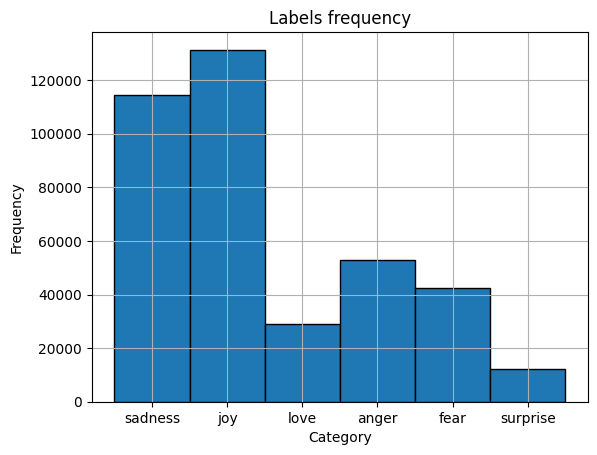

In [12]:
mv.plot_histogram(
    df['label'], 
    value_label_dict, 
    title='Labels frequency', 
    filepath='images\EDA_labels_frequency')

### Texts length distribution

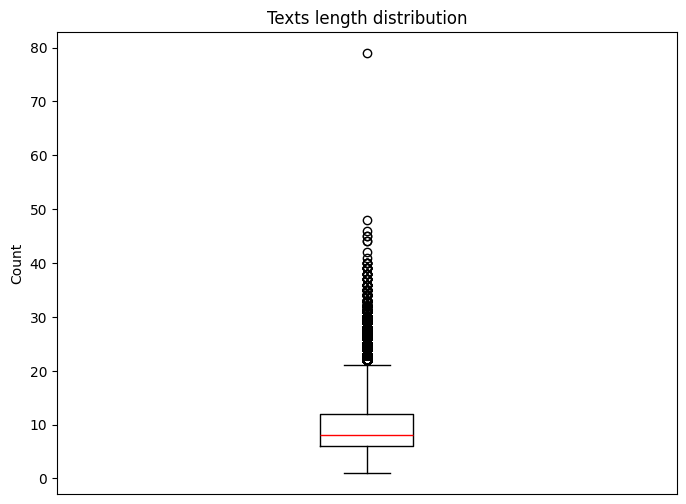

In [13]:
elements_length = df['text_tokenized_to_numeric'].apply(len)

mv.plot_boxplot(
    elements_length, 
    title="Texts length distribution", 
    filepath="images\EDA_text_length_distribution")

### Common words frequency

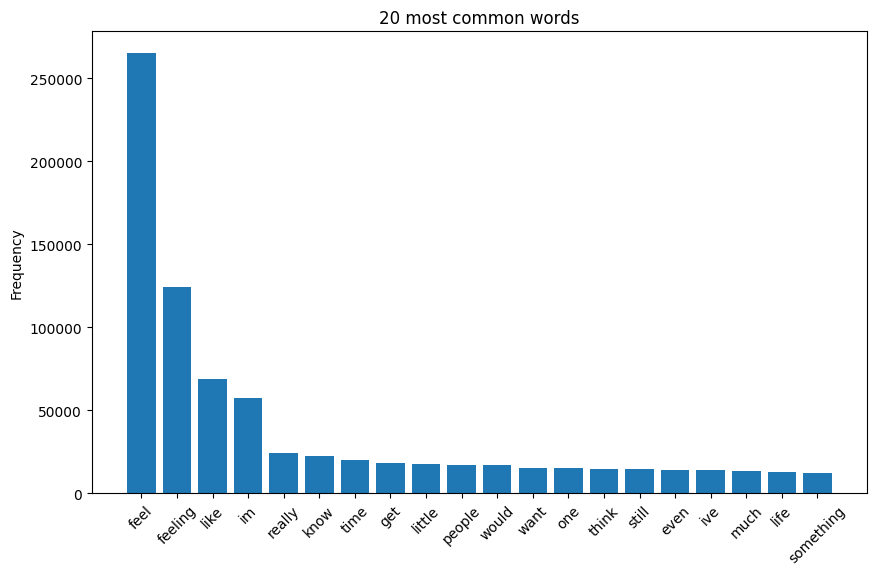

In [14]:
all_text = ' '.join(df['text'])
words_counter = collections.Counter(all_text.split())

words_num = 20
most_common_words = words_counter.most_common(words_num)
words, counts = zip(*most_common_words)

mv.plot_bar(
    words, 
    counts, 
    title=f'{words_num} most common words', 
    filepath='images\EDA_most_common_words')

## Model Building and Configuration

### LSTM model architecture

In [15]:
def create_LSTM_model(params):
    model = Sequential([
        Embedding(input_dim=params['input_dim'], output_dim=params['output_dim'], input_length=params['input_length']),
        LSTM(params['lstm_units'], return_sequences=True),
        Dropout(params['dropout']),
        Flatten(),
        Dense(params['dense_units'], activation='relu', kernel_regularizer=l1_l2(params['l1'], params['l2'])),  
        Dropout(params['dropout']),
        Dense(params['num_classes'], activation='softmax')
    ])
    model.compile(
        optimizer='adam', 
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    
    return model

### Bidirectional LSTM model architecture

In [16]:
def create_BiLSTM_model(params):
    model = Sequential([
        Embedding(input_dim=params['input_dim'], output_dim=params['output_dim'], input_length=params['input_length']),
        Bidirectional(LSTM(params['lstm_units'], return_sequences=True)),
        Dropout(params['dropout']),
        Flatten(),
        Dense(params['dense_units'], activation='relu', kernel_regularizer=l1_l2(params['l1'], params['l2'])),  
        Dropout(params['dropout']),
        Dense(params['num_classes'], activation='softmax')
    ])
    model.compile(
        optimizer='adam', 
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    
    return model

### GRU model architecture

In [17]:
def create_GRU_model(params):
    model = Sequential([
        Embedding(input_dim=params['input_dim'], output_dim=params['output_dim'], input_length=params['input_length']),
        GRU(params['lstm_units'], return_sequences=True),
        Dropout(params['dropout']),
        Flatten(),
        Dense(params['dense_units'], activation='relu', kernel_regularizer=l1_l2(params['l1'], params['l2'])),  
        Dropout(params['dropout']),
        Dense(params['num_classes'], activation='softmax')
    ])
    model.compile(
        optimizer='adam', 
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

### Model training configuration

In [18]:
def save_json(content, filepath):
    with open(filepath, 'w') as f:
        json.dump(content, f)
        
def train_model(model, X_train, y_train, model_dir, training_params):
    os.makedirs(model_dir, exist_ok=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    model_checkpoint = ModelCheckpoint(
        filepath=os.path.join(model_dir, 'model.keras'), 
        monitor='val_loss', save_best_only=True, mode='min')
    
    classes = np.array(list(value_label_dict.keys()))
    class_weights = compute_class_weight('balanced', classes=classes, y=y_train)

    history = model.fit(
        X_train, 
        y_train, 
        epochs=training_params['epochs'], 
        batch_size=training_params['batch_size'], 
        validation_split=0.2, 
        class_weight = dict(enumerate(class_weights)),
        callbacks=[early_stopping, model_checkpoint])

    save_json(history.history, filepath=os.path.join(model_dir, 'history.json'))
    mp.save_tokenizer(tokenizer, filepath=os.path.join(model_dir, 'tokenizer.json'))

    return model, history.history

## Hyperparameter Tuning and Training

### MLfLow Metrics and Artifacts Setup

In [ ]:
def log_metrics_and_artifacts(model, X_test, y_test, model_history, run_name):
    # Calculate test metrics
    y_test_pred = np.argmax(model.predict(X_test), axis=1)
    report = classification_report(y_test, y_test_pred, output_dict=True, zero_division=1)

    # Log training metrics
    mlflow.log_metric("loss_train", model_history['loss'][-1])
    mlflow.log_metric("loss_validation", model_history['val_loss'][-1])
    mlflow.log_metric("accuracy_train", model_history['accuracy'][-1])
    mlflow.log_metric("accuracy_validation", model_history['val_accuracy'][-1])

    # Log test metrics
    mlflow.log_metric("accuracy_test", report["accuracy"])
    mlflow.log_metric("precision_test", report["weighted avg"]["precision"])
    mlflow.log_metric("recall_test", report["weighted avg"]["recall"])
    mlflow.log_metric("f1_score_test", report["weighted avg"]["f1-score"])

    # Plot and log the loss plot
    image_path = f'images/mlruns/{run_name}_loss.png'
    mv.plot_simple(
        model_history['loss'],
        model_history['val_loss'],
        report["loss"],
        xlabel="Epoch Number",
        ylabel='Loss',
        filepath=image_path
    )
    
    # Plot and log the loss plot
    image_path = f'images/mlruns/{run_name}_accuracy.png'
    mv.plot_simple(
        model_history['accuracy'],
        model_history['val_accuracy'],
        report["accuracy"],
        xlabel="Epoch Number",
        ylabel='Accuracy',
        filepath=image_path
    )

    # Log the model
    y_pred_sample = model.predict(np.array([X_test[0]]))
    signature = infer_signature(X_test, y_pred_sample)
    mlflow.keras.log_model(model, run_name, signature=signature)

### MLfLow Experiment Setup

In [ ]:
def run_experiment(create_model_fn, model_name, X_train, y_train, X_test, y_test, model_params, training_params):
    # Initialize MLflow
    run_name = f"{model_name} [lstm_units={model_params['lstm_units']}, dropout={model_params['dropout']}, dense_units={model_params['dense_units']}]"
    model_dir = f'models/{run_name}'

    mlflow.set_experiment("Grid search [lstm_units, dropout, dense_units]")
    with mlflow.start_run(run_name=run_name):
        print(f"Started run for '{run_name}'")

        # Log parameters
        for param, value in {**model_params, **training_params}.items():
            mlflow.log_param(param, value)

        # Create and train model
        model = create_model_fn(model_params)
        model, model_history = train_model(model, X_train, y_train, model_dir, training_params)

        # Evaluate model
        log_metrics_and_artifacts(model, X_test, y_test, model_history, run_name)

        print(f"Run Completed")

### Hyperparameter Grid Search

In [ ]:
init_model_params = {
    'input_dim': unique_words_count + 1,
    'output_dim': 64,
    'input_length': 40,
    'lstm_units': 16,
    'dense_units': 16,
    'l1': 0.00001,
    'l2': 0.0001,
    'dropout': 0.2,
    'num_classes': 6
}

init_training_params = {
    'epochs': 20,
    'batch_size': 25000
}

param_grid = {
    'lstm_units': [16, 32],
    'dense_units': [16, 32],
    'dropout': [0.4],    
 }

model_functions = {
      "LSTM": create_LSTM_model,
      "GRU": create_GRU_model,
      "BiLSTM": create_BiLSTM_model,
}

all_param_combinations = list(itertools.product(
    param_grid["lstm_units"],
    param_grid["dropout"],
    param_grid["dense_units"],
))

for model_name, create_model_fn in model_functions.items():
    for lstm_units, dropout, dense_units in all_param_combinations:
        # Set model-specific parameters
        model_params = init_model_params.copy()        
        model_params['lstm_units'] = lstm_units
        model_params['dropout'] = dropout
        model_params['dense_units'] = dense_units
        
        training_params = init_training_params.copy()

        # Set training parameters
        training_params = init_training_params.copy()

        # Run experiment for this model and parameter combination
        run_experiment(create_model_fn, model_name, X_train, y_train, X_test, y_test, model_params, training_params)

## Model Evaluation and Validation

### Selected Model Loading

In [22]:
best_model_dir = os.path.join("models", "GRU [lstm_units=32, dropout=0.4, dense_units=32]")

def load_json(dir, filename):
    filepath = os.path.join(dir, filename)
    with open(filepath, 'r') as f:
        loaded_json = json.load(f)
    return loaded_json

best_model = load_model(os.path.join(best_model_dir, 'model.keras'))
best_model_history = load_json(best_model_dir, filename = 'history.json')

### Loss & Accuracy

2389/2389 [==============================] - 4s 2ms/step - loss: 0.3568 - accuracy: 0.9027
[Test data] Loss : 0.35683995485305786
[Test data] Accuracy : 0.9026703834533691


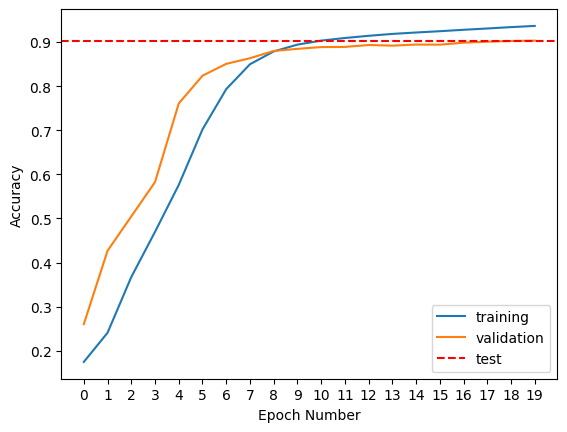

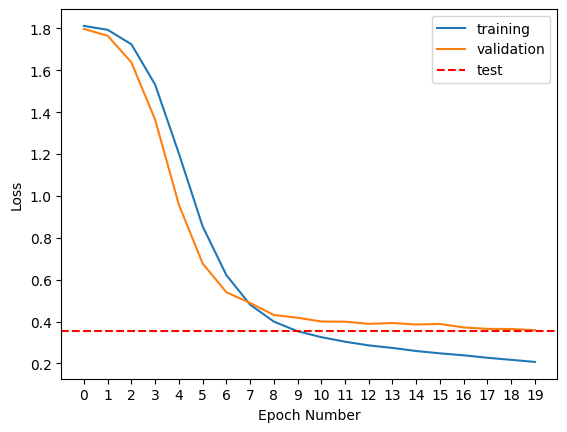

In [23]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

print(f"[Test data] Loss : {test_loss}")
print(f"[Test data] Accuracy : {test_accuracy}")

mv.plot_simple(
        best_model_history['accuracy'], 
        best_model_history['val_accuracy'], 
        test_accuracy,
        xlabel="Epoch Number", 
        ylabel='Accuracy',
        filepath='images\GRU_accuracy_history')

mv.plot_simple(
        best_model_history['loss'], 
        best_model_history['val_loss'], 
        test_loss,
        xlabel="Epoch Number", 
        ylabel="Loss",
        filepath='images\GRU_loss_history')

### Classification report

In [24]:
y_test_pred = np.argmax(best_model.predict(X_test), axis=1)
report = classification_report(y_test, y_test_pred)

print(report)

2389/2389 [==============================] - 4s 2ms/step
              precision    recall  f1-score   support

           0       0.95      0.92      0.93     22879
           1       0.95      0.88      0.92     26265
           2       0.73      0.89      0.80      5769
           3       0.88      0.92      0.90     10603
           4       0.86      0.90      0.88      8475
           5       0.75      0.89      0.81      2440

    accuracy                           0.90     76431
   macro avg       0.85      0.90      0.87     76431
weighted avg       0.91      0.90      0.90     76431



### Confusion matrix

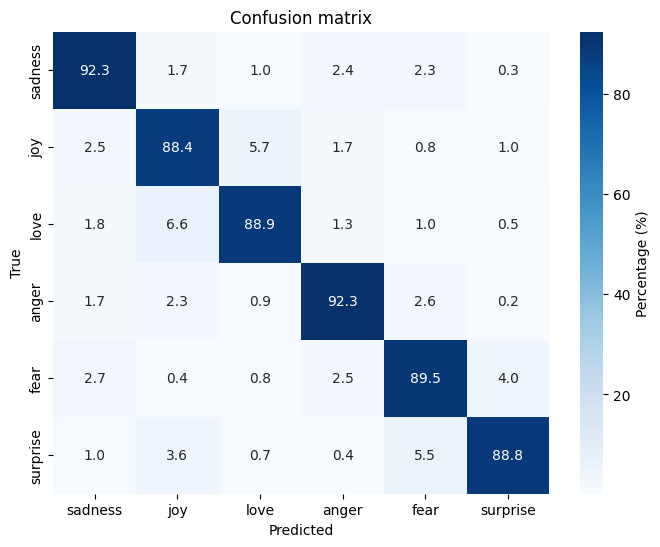

In [25]:
mv.plot_confusion_matrix(
    y_test, 
    y_test_pred, 
    class_names=value_label_dict.values(), 
    filepath='images\GRU_confusion_matrix')